In [32]:
# Importing modules
import numpy as np
import pandas as pd
import numba
import pyarrow.dataset as ds
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner
from sklearn.cluster import KMeans


In [2]:
# Pandas display options (personal preference)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

In [3]:
# Importing the G09 parquet file
dataset = ds.dataset("../../data/All_DDF/All_DDF_2p4.parquet", format="parquet")
table = dataset.to_table()

# Setting uberID as index
df = table.to_pandas().set_index('uberID')
df.index=df.index.astype('int64')

del dataset,table

In [4]:
# Getting rid of weird spaces in the class column
df=df.replace({'class': {'ambiguous ': 'ambiguous',
                         'star      ': 'star', 
                         'galaxy    ': 'galaxy', 
                         'artefact  ':'artefact'}})

In [5]:
# Making a number of cuts: magnitude, mask, starmask and removing artefacts
df=df[(df['mag_Zt']<22) & 
      (df['mask']==0) & 
      (df['starmask']==0) & 
      (df['class']!='artefact')&
      (df['duplicate']==0)
]

In [6]:
# Getting a 1/10 subset of the data (for the purpose of this tutorial)
# df=df[::10]

In [7]:
df

,FrameName,FrameID,segID,xmax,ymax,censep,RAcen,Deccen,RAmax,Decmax,RAGAIA_r,RAGAIA,DecGAIA,DecGAIA_r,RAGAIA_r_cen,DecGAIA_r_cen,RAcen_gt,Deccen_gt,RAmax_gt,Decmax_gt,RAcen_rt,Deccen_rt,RAmax_rt,Decmax_rt,RAcen_Zt,Deccen_Zt,RAmax_Zt,Decmax_Zt,sky_mean,skyRMS_mean,log10seeing,log10seeing_r,log10seeing_i,log10seeing_Z,log10seeing_Y,mag,EBV,R50,R50_gt,R50_rt,R50_Yt,R50_Jt,R50_Ht,R90,R100,N100,axrat,ang,groupID,Ngroup,mag_app_Zt,mag_Zt,mag_app_gt,mag_app_rt,mag_app_it,mag_app_Yt,flux_ut,flux_err_ut,flux_ut_uncorrected,flux_err_ut_uncorrected,flux_gt,flux_err_gt,flux_gt_uncorrected,flux_err_gt_uncorrected,flux_rt,flux_err_rt,flux_rt_uncorrected,flux_err_rt_uncorrected,flux_it,flux_err_it,flux_it_uncorrected,flux_err_it_uncorrected,flux_Zt,flux_err_Zt,flux_Zt_uncorrected,flux_err_Zt_uncorrected,flux_Yt,flux_err_Yt,flux_Yt_uncorrected,flux_err_Yt_uncorrected,flux_Jt,flux_err_Jt,flux_Jt_uncorrected,flux_err_Jt_uncorrected,flux_Ht,flux_err_Ht,flux_Ht_uncorrected,flux_err_Ht_uncorrected,flux_Kt,flux_err_Kt,flux_Kt_uncorrected,flux_err_Kt_uncorrected,flux_W1t,flux_err_W1t,flux_W1t_uncorrected,flux_err_W1t_uncorrected,flux_W2t,flux_err_W2t,flux_W2t_uncorrected,flux_err_W2t_uncorrected,flux_uc,flux_err_uc,flux_gc,flux_err_gc,flux_rc,flux_err_rc,flux_ic,flux_err_ic,flux_Zc,flux_err_Zc,flux_Yc,flux_err_Yc,flux_Jc,flux_err_Jc,flux_Hc,flux_err_Hc,flux_Kc,flux_err_Kc,flux_W1c,flux_err_W1c,flux_W2c,flux_err_W2c,mask,starmask,starscol,starssize,class,noOPT_r,noOPT_i,noIR_Z,noIR_Y,duplicate,mag_Zc,mag_Zt_fake
uberID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9581275900715,waves_postprocessed_10.0_-42.5.rds,958.0,102,12758.5,714.5,8550.818440,9.343646,-43.021880,9.343656,-43.021902,9.343692,9.343692,-43.021909,-43.021909,9.343651,-43.021933,9.343593,-43.021931,9.343656,-43.021902,9.343615,-43.021925,9.343656,-43.021902,9.343647,-43.021879,9.343656,-43.021902,-0.000268,0.002855,-0.123168,-0.119852,NaN,-0.120193,-0.166938,15.445208,0.010967,0.708051,0.788300,0.832923,0.632877,0.626473,0.617132,2.190448,10.772246,3931,0.970473,37.632057,102,7,16.090195,15.425893,18.923794,17.929803,16.862768,15.742158,1.855132e-05,4.099015e-07,1.767128e-05,3.904567e-07,2.082387e-04,4.829733e-07,2.006712e-04,4.654220e-07,6.009600e-04,6.210577e-07,5.850600e-04,6.046259e-07,1.546757e-03,1.745950e-06,1.514680e-03,1.709742e-06,0.002453,1.801823e-06,0.002415,1.773792e-06,3.164216e-03,3.275237e-06,3.125686e-03,3.235355e-06,0.003390,2.071104e-06,0.003360,2.052854e-06,0.003829,0.000002,0.003807,0.000002,0.003332,0.000005,0.003319,0.000005,0.001478,1.081058e-06,0.001475,1.078862e-06,0.000812,1.370060e-06,0.000811,1.368127e-06,1.781384e-05,3.174351e-07,2.078269e-04,3.476345e-07,5.974202e-04,4.385488e-07,1.538027e-03,1.278125e-06,2.444458e-03,9.641469e-07,3.151734e-03,1.632721e-06,3.377145e-03,9.881185e-07,3.808610e-03,8.762329e-07,3.312674e-03,2.606886e-06,1.412067e-03,3.848968e-07,7.693408e-04,7.103664e-07,0.0,0.0,3.0,3.0,star,0.0,0.0,0.0,0.0,0.0,15.429544,0
9580381200351,waves_postprocessed_10.0_-42.5.rds,958.0,126,3811.5,350.5,6311.182536,10.363559,-43.053557,10.363609,-43.053532,10.363645,10.363645,-43.053540,-43.053540,10.363605,-43.053515,10.363587,-43.053519,10.363609,-43.053532,10.363569,-43.053508,10.363609,-43.053532,10.363559,-43.053558,10.363609,-43.053532,-0.000318,0.003008,-0.123168,-0.119852,NaN,-0.120193,-0.166938,15.796832,0.009750,0.718228,0.784847,0.739774,0.655162,0.601938,0.601977,2.223768,10.838887,4083,0.995641,18.196750,126,5,16.483180,15.780808,17.991782,17.167115,16.668889,16.239497,5.080385e-05,4.317074e-07,4.865544e-05,4.134512e-07,5.169781e-04,5.672629e-07,5.002410e-04,5.488978e-07,1.129341e-03,8.891435e-07,1.102736e-03,8.681974e-07,1.575814e-03,2.778281e-06,1.546725e-03,2.726995e-06,0.001769,2.302459e-06,0.001744,2.270586e-06,2.044855e-03,1.664141e-06,2.022703e-03,1.646113e-06,0.002077,1.931805e-06,0.002060,1.916664e-06,0.002246,0.000007,0.002234,0.000007,0.00

In [8]:
# Reading the u and no u labels from notebooks 1 and 2, and creating new dataframes
df_u=pd.read_csv('../../data/All_DDF/All_DDF_u.csv').set_index('uberID')
df_no_u=pd.read_csv('../../data/All_DDF/All_DDF_no_u.csv').set_index('uberID')

In [9]:
# Creating new columns in the main dataframe with u and no u labels
df['cluster_label']=np.zeros(len(df))
df['cluster_label_no_u']=np.zeros(len(df))
df['label_type']=np.zeros(len(df))
df['label_type']='missing_band'

In [10]:
# Creating umap columns in the main dataframe with u and no u labels
for i in range(10):
    df[f'umap{i+1}_no_u'] = np.zeros(len(df))
for i in range(10):    
    df[f'umap{i+1}_u'] = np.zeros(len(df))

In [11]:
# Filling the new columns with u and no u labels
df.loc[df_u.index,'cluster_label']=df_u['cluster_label'].apply(str)
df.loc[df_no_u.index,'cluster_label_no_u']=df_no_u['cluster_label'].apply(str)

/tmp/ipykernel_399520/2692133000.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['star' 'star' 'star' ... 'galaxy' 'galaxy' 'galaxy']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df_u.index,'cluster_label']=df_u['cluster_label'].apply(str)
/tmp/ipykernel_399520/2692133000.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['star' 'star' 'star' ... 'galaxy' 'galaxy' 'galaxy']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df_no_u.index,'cluster_label_no_u']=df_no_u['cluster_label'].apply(str)


In [12]:
for i in range(10):
    df.loc[df_u.index,f'umap{i+1}_u']=df_u[f'umap{i+1}']
    df.loc[df_no_u.index,f'umap{i+1}_no_u']=df_no_u[f'umap{i+1}']

In [13]:
labels=['star','galaxy']

In [14]:
# Creating a 'final label' column full of 1's to combine the two labels
df['final_label']=np.ones(len(df))


In [15]:
# Creating umap columns with 1's
for i in range(10):
    df[f'umap{i+1}'] = np.ones(len(df))


In [16]:
# First applying the no u labels to the final label
for label in labels:
    df.loc[df[df['cluster_label_no_u']==label].index,'final_label']=label
    df.loc[df[df['cluster_label_no_u']==label].index,'label_type']='no_u'
    # First putting umap columns with no u labels
    for i in range(10):
        df.loc[df[df['cluster_label_no_u']==label].index, f'umap{i+1}'] = df.loc[df[df['cluster_label_no_u']==label].index, f'umap{i+1}_no_u']

/tmp/ipykernel_399520/3128810293.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'star' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df[df['cluster_label_no_u']==label].index,'final_label']=label


In [17]:
# Then applying the u labels to the final label, overwriting any existing no u labels
for label in labels:
    df.loc[df[df['cluster_label']==label].index,'final_label']=label
    df.loc[df[df['cluster_label']==label].index,'label_type']='u'
    for i in range(10):
        df.loc[df[df['cluster_label']==label].index, f'umap{i+1}'] = df.loc[df[df['cluster_label']==label].index, f'umap{i+1}_u']

In [18]:
# Convering final label to string
df['final_label']=df['final_label'].apply(str)

In [19]:
# Creating a new column to indicate whether a source has any missing bands.
# If final label still == 1, that indicates a label hasn't been added, so it has a missing band
df['missing_bands']=True
df.loc[df[df['final_label']!='1.0'].index,'missing_bands']=False


In [20]:
# For the sources with missing labels we then overwrite with class
df.loc[df[df['final_label']=='1.0'].index,'final_label'] = df[df['final_label']=='1.0']['class']

In [21]:
# For sources with missing labels we put nan in the umap columns
for i in range(10):
    df.loc[df[df['missing_bands']==True].index, f'umap{i+1}'] = np.nan

In [22]:
# Sources with missing bands are only 1.5% of the sample
len(df[df['missing_bands']==True])/len(df)

0.03573092747732117

In [23]:
df

,FrameName,FrameID,segID,xmax,ymax,censep,RAcen,Deccen,RAmax,Decmax,RAGAIA_r,RAGAIA,DecGAIA,DecGAIA_r,RAGAIA_r_cen,DecGAIA_r_cen,RAcen_gt,Deccen_gt,RAmax_gt,Decmax_gt,RAcen_rt,Deccen_rt,RAmax_rt,Decmax_rt,RAcen_Zt,Deccen_Zt,RAmax_Zt,Decmax_Zt,sky_mean,skyRMS_mean,log10seeing,log10seeing_r,log10seeing_i,log10seeing_Z,log10seeing_Y,mag,EBV,R50,R50_gt,R50_rt,R50_Yt,R50_Jt,R50_Ht,R90,R100,N100,axrat,ang,groupID,Ngroup,mag_app_Zt,mag_Zt,mag_app_gt,mag_app_rt,mag_app_it,mag_app_Yt,flux_ut,flux_err_ut,flux_ut_uncorrected,flux_err_ut_uncorrected,flux_gt,flux_err_gt,flux_gt_uncorrected,flux_err_gt_uncorrected,flux_rt,flux_err_rt,flux_rt_uncorrected,flux_err_rt_uncorrected,flux_it,flux_err_it,flux_it_uncorrected,flux_err_it_uncorrected,flux_Zt,flux_err_Zt,flux_Zt_uncorrected,flux_err_Zt_uncorrected,flux_Yt,flux_err_Yt,flux_Yt_uncorrected,flux_err_Yt_uncorrected,flux_Jt,flux_err_Jt,flux_Jt_uncorrected,flux_err_Jt_uncorrected,flux_Ht,flux_err_Ht,flux_Ht_uncorrected,flux_err_Ht_uncorrected,flux_Kt,flux_err_Kt,flux_Kt_uncorrected,flux_err_Kt_uncorrected,flux_W1t,flux_err_W1t,flux_W1t_uncorrected,flux_err_W1t_uncorrected,flux_W2t,flux_err_W2t,flux_W2t_uncorrected,flux_err_W2t_uncorrected,flux_uc,flux_err_uc,flux_gc,flux_err_gc,flux_rc,flux_err_rc,flux_ic,flux_err_ic,flux_Zc,flux_err_Zc,flux_Yc,flux_err_Yc,flux_Jc,flux_err_Jc,flux_Hc,flux_err_Hc,flux_Kc,flux_err_Kc,flux_W1c,flux_err_W1c,flux_W2c,flux_err_W2c,mask,starmask,starscol,starssize,class,noOPT_r,noOPT_i,noIR_Z,noIR_Y,duplicate,mag_Zc,mag_Zt_fake,cluster_label,cluster_label_no_u,label_type,umap1_no_u,umap2_no_u,umap3_no_u,umap4_no_u,umap5_no_u,umap6_no_u,umap7_no_u,umap8_no_u,umap9_no_u,umap10_no_u,umap1_u,umap2_u,umap3_u,umap4_u,umap5_u,umap6_u,umap7_u,umap8_u,umap9_u,umap10_u,final_label,umap1,umap2,umap3,umap4,umap5,umap6,umap7,umap8,umap9,umap10,missing_bands
uberID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9581275900715,waves_postprocessed_10.0_-42.5.rds,958.0,102,12758.5,714.5,8550.818440,9.343646,-43.021880,9.343656,-43.021902,9.343692,9.343692,-43.021909,-43.021909,9.343651,-43.021933,9.343593,-43.021931,9.343656,-43.021902,9.343615,-43.021925,9.343656,-43.021902,9.343647,-43.021879,9.343656,-43.021902,-0.000268,0.002855,-0.123168,-0.119852,NaN,-0.120193,-0.166938,15.445208,0.010967,0.708051,0.788300,0.832923,0.632877,0.626473,0.617132,2.190448,10.772246,3931,0.970473,37.632057,102,7,16.090195,15.425893,18.923794,17.929803,16.862768,15.742158,1.855132e-05,4.099015e-07,1.767128e-05,3.904567e-07,2.082387e-04,4.829733e-07,2.006712e-04,4.654220e-07,6.009600e-04,6.210577e-07,5.850600e-04,6.046259e-07,1.546757e-03,1.745950e-06,1.514680e-03,1.709742e-06,0.002453,1.801823e-06,0.002415,1.773792e-06,3.164216e-03,3.275237e-06,3.125686e-03,3.235355e-06,0.003390,2.071104e-06,0.003360,2.052854e-06,0.003829,0.000002,0.003807,0.000002,0.003332,0.000005,0.003319,0.000005,0.001478,1.081058e-06,0.001475,1.078862e-06,0.000812,1.370060e-06,0.000811,1.368127e-06,1.781384e-05,3.174351e-07,2.078269e-04,3.476345e-07,5.974202e-04,4.385488e-07,1.538027e-03,1.278125e-06,2.444458e-03,9.641469e-07,3.151734e-03,1.632721e-06,3.377145e-03,9.881185e-07,3.808610e-03,8.762329e-07,3.312674e-03,2.606886e-06,1.412067e-03,3.848968e-07,7.693408e-04,7.103664e-07,0.0,0.0,3.0,3.0,star,0.0,0.0,0.0,0.0,0.0,15.429544,0,star,star,u,9.360000,7.965523,0.846073,8.811650,3.829969,4.802040,8.277063,5.855236,3.763412,7.104206,8.512201,0.947558,1.083208,8.826461,4.052917,4.121770,8.239983,5.463573,5.148250,5.651849,star,8.512201,0.947558,1.083208,8.826461,4.052917,4.121770,8.239983,5.463573,5.148250,5.651849,False
9580381200351,waves_postprocessed_10.0_-42.5.rds,958.0,126,3811.5,350.5,6311.182536,10.363559,-43.053557,10.363609,-43.053532,10.363645,10.363645,-43.053540,-43.053540,10.363605,-43.053515,10.363587,-43.053519,10.363609,-43.053532,10.363569,-43.053508,10.363609,-43.053532,10.363559,-43.053558,10.

In [24]:
df[df['missing_bands']==False]

,FrameName,FrameID,segID,xmax,ymax,censep,RAcen,Deccen,RAmax,Decmax,RAGAIA_r,RAGAIA,DecGAIA,DecGAIA_r,RAGAIA_r_cen,DecGAIA_r_cen,RAcen_gt,Deccen_gt,RAmax_gt,Decmax_gt,RAcen_rt,Deccen_rt,RAmax_rt,Decmax_rt,RAcen_Zt,Deccen_Zt,RAmax_Zt,Decmax_Zt,sky_mean,skyRMS_mean,log10seeing,log10seeing_r,log10seeing_i,log10seeing_Z,log10seeing_Y,mag,EBV,R50,R50_gt,R50_rt,R50_Yt,R50_Jt,R50_Ht,R90,R100,N100,axrat,ang,groupID,Ngroup,mag_app_Zt,mag_Zt,mag_app_gt,mag_app_rt,mag_app_it,mag_app_Yt,flux_ut,flux_err_ut,flux_ut_uncorrected,flux_err_ut_uncorrected,flux_gt,flux_err_gt,flux_gt_uncorrected,flux_err_gt_uncorrected,flux_rt,flux_err_rt,flux_rt_uncorrected,flux_err_rt_uncorrected,flux_it,flux_err_it,flux_it_uncorrected,flux_err_it_uncorrected,flux_Zt,flux_err_Zt,flux_Zt_uncorrected,flux_err_Zt_uncorrected,flux_Yt,flux_err_Yt,flux_Yt_uncorrected,flux_err_Yt_uncorrected,flux_Jt,flux_err_Jt,flux_Jt_uncorrected,flux_err_Jt_uncorrected,flux_Ht,flux_err_Ht,flux_Ht_uncorrected,flux_err_Ht_uncorrected,flux_Kt,flux_err_Kt,flux_Kt_uncorrected,flux_err_Kt_uncorrected,flux_W1t,flux_err_W1t,flux_W1t_uncorrected,flux_err_W1t_uncorrected,flux_W2t,flux_err_W2t,flux_W2t_uncorrected,flux_err_W2t_uncorrected,flux_uc,flux_err_uc,flux_gc,flux_err_gc,flux_rc,flux_err_rc,flux_ic,flux_err_ic,flux_Zc,flux_err_Zc,flux_Yc,flux_err_Yc,flux_Jc,flux_err_Jc,flux_Hc,flux_err_Hc,flux_Kc,flux_err_Kc,flux_W1c,flux_err_W1c,flux_W2c,flux_err_W2c,mask,starmask,starscol,starssize,class,noOPT_r,noOPT_i,noIR_Z,noIR_Y,duplicate,mag_Zc,mag_Zt_fake,cluster_label,cluster_label_no_u,label_type,umap1_no_u,umap2_no_u,umap3_no_u,umap4_no_u,umap5_no_u,umap6_no_u,umap7_no_u,umap8_no_u,umap9_no_u,umap10_no_u,umap1_u,umap2_u,umap3_u,umap4_u,umap5_u,umap6_u,umap7_u,umap8_u,umap9_u,umap10_u,final_label,umap1,umap2,umap3,umap4,umap5,umap6,umap7,umap8,umap9,umap10,missing_bands
uberID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9581275900715,waves_postprocessed_10.0_-42.5.rds,958.0,102,12758.5,714.5,8550.818440,9.343646,-43.021880,9.343656,-43.021902,9.343692,9.343692,-43.021909,-43.021909,9.343651,-43.021933,9.343593,-43.021931,9.343656,-43.021902,9.343615,-43.021925,9.343656,-43.021902,9.343647,-43.021879,9.343656,-43.021902,-0.000268,0.002855,-0.123168,-0.119852,NaN,-0.120193,-0.166938,15.445208,0.010967,0.708051,0.788300,0.832923,0.632877,0.626473,0.617132,2.190448,10.772246,3931,0.970473,37.632057,102,7,16.090195,15.425893,18.923794,17.929803,16.862768,15.742158,1.855132e-05,4.099015e-07,1.767128e-05,3.904567e-07,2.082387e-04,4.829733e-07,2.006712e-04,4.654220e-07,0.000601,6.210577e-07,0.000585,6.046259e-07,1.546757e-03,1.745950e-06,1.514680e-03,1.709742e-06,0.002453,1.801823e-06,0.002415,1.773792e-06,0.003164,3.275237e-06,0.003126,3.235355e-06,0.003390,2.071104e-06,0.003360,2.052854e-06,0.003829,0.000002,0.003807,0.000002,0.003332,0.000005,0.003319,0.000005,0.001478,1.081058e-06,0.001475,1.078862e-06,0.000812,1.370060e-06,0.000811,1.368127e-06,1.781384e-05,3.174351e-07,2.078269e-04,3.476345e-07,5.974202e-04,4.385488e-07,1.538027e-03,1.278125e-06,2.444458e-03,9.641469e-07,3.151734e-03,1.632721e-06,3.377145e-03,9.881185e-07,3.808610e-03,8.762329e-07,0.003313,2.606886e-06,1.412067e-03,3.848968e-07,7.693408e-04,7.103664e-07,0.0,0.0,3.0,3.0,star,0.0,0.0,0.0,0.0,0.0,15.429544,0,star,star,u,9.360000,7.965523,0.846073,8.811650,3.829969,4.802040,8.277063,5.855236,3.763412,7.104206,8.512201,0.947558,1.083208,8.826461,4.052917,4.121770,8.239983,5.463573,5.148250,5.651849,star,8.512201,0.947558,1.083208,8.826461,4.052917,4.121770,8.239983,5.463573,5.148250,5.651849,False
9580381200351,waves_postprocessed_10.0_-42.5.rds,958.0,126,3811.5,350.5,6311.182536,10.363559,-43.053557,10.363609,-43.053532,10.363645,10.363645,-43.053540,-43.053540,10.363605,-43.053515,10.363587,-43.053519,10.363609,-43.053532,10.363569,-43.053508,10.363609,-43.053532,10.363559,-43.053558,10.363609,-43.053532,-0

In [25]:
df['uberID']=df.index

In [26]:
df = df.rename(columns={'cluster_label':'cluster_label_u'})

In [27]:
# Saving
df.to_csv('../../data/All_DDF/All_DDF_UMAP_full.csv')

In [28]:
columns_to_save = ['uberID', 'RAmax', 'Decmax', 'mag_Zt','final_label', 'missing_bands', 'umap1', 'umap2', 'umap3', 'umap4', 'umap5', 'umap6', 'umap7', 'umap8', 'umap9', 'umap10', 'class',
                   'cluster_label_u', 'cluster_label_no_u', 'label_type', 'umap1_u', 'umap2_u', 'umap3_u', 'umap4_u', 'umap5_u', 'umap6_u', 'umap7_u', 'umap8_u', 'umap9_u', 'umap10_u',
                   'umap1_no_u', 'umap2_no_u', 'umap3_no_u', 'umap4_no_u', 'umap5_no_u', 'umap6_no_u', 'umap7_no_u', 'umap8_no_u', 'umap9_no_u', 'umap10_no_u']

In [29]:
df[columns_to_save].to_csv('../../data/All_DDF/All_DDF_UMAP_reduced_columns.csv')

In [30]:
len(df[df['final_label']=='galaxy'])

327524

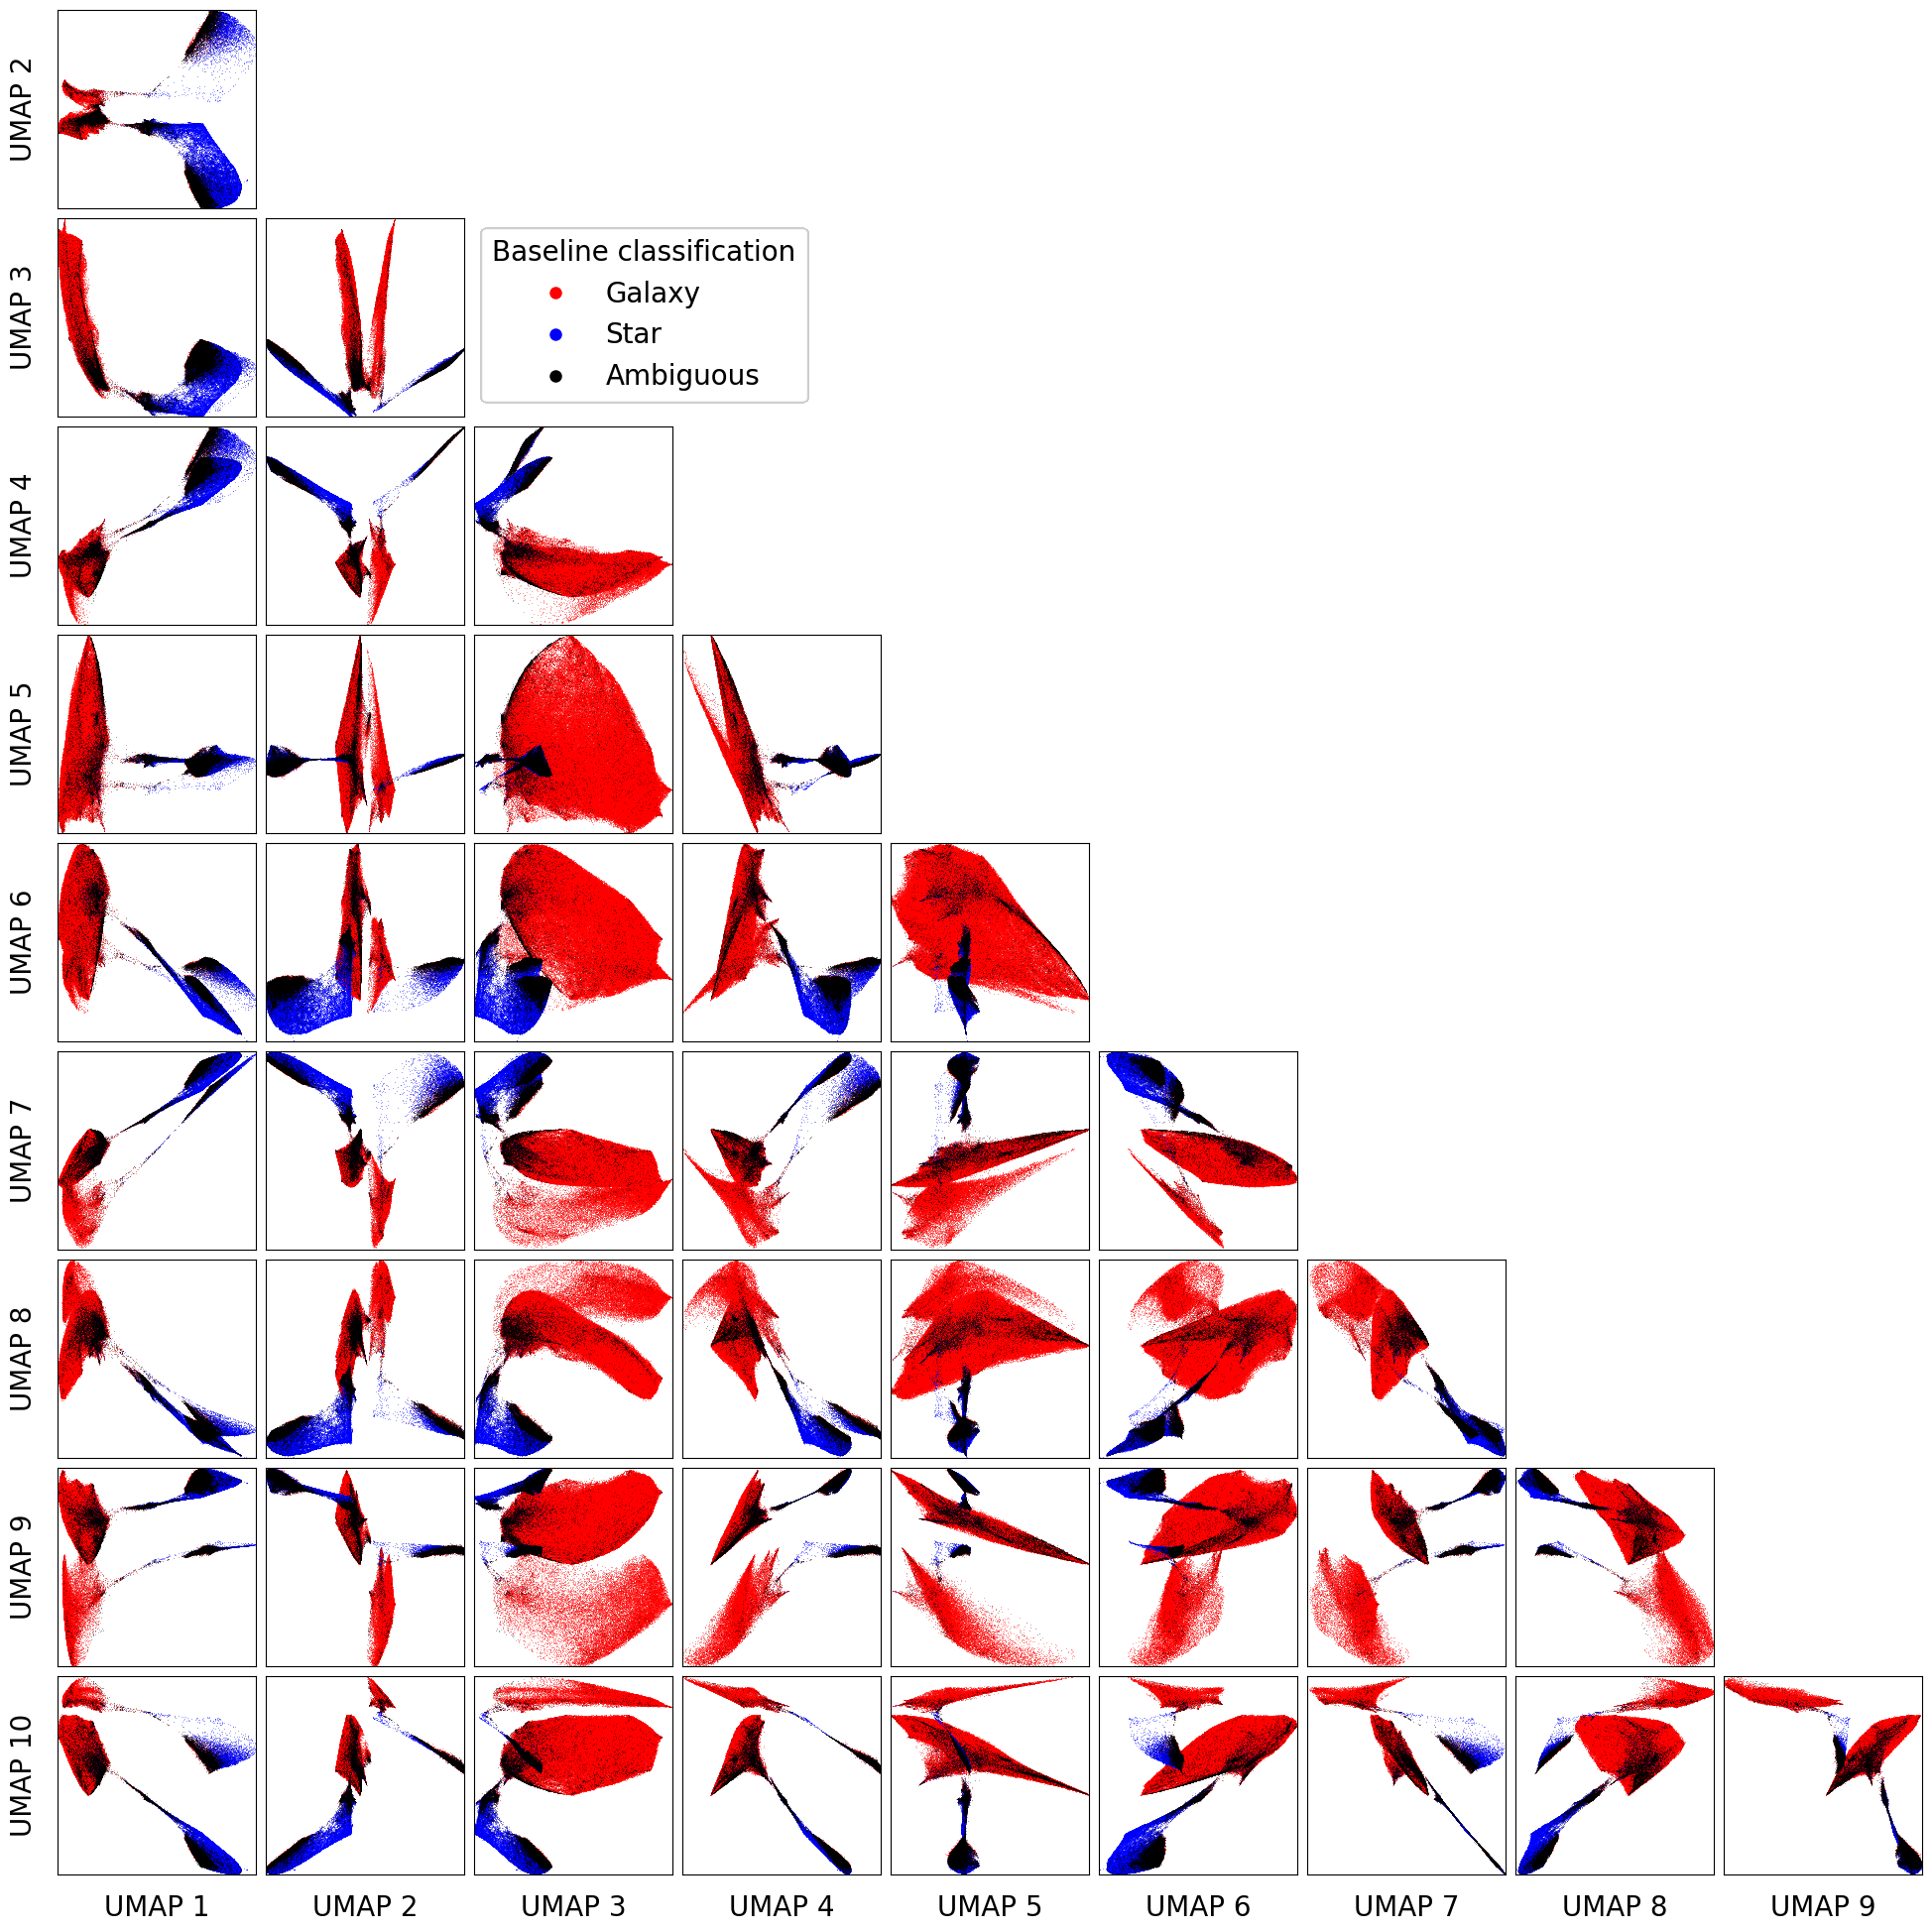

In [35]:
#Corner plot of all 10 UMAP features

UMAPs = [f'UMAP {i}' for i in range(1, 11)]
umaps = [f'umap{i}' for i in range(1, 11)]

X_galaxy=np.array(df[df['class']=='galaxy'][umaps].dropna())
X_star=np.array(df[df['class']=='star'][umaps].dropna())
X_ambiguous=np.array(df[df['class']=='ambiguous'][umaps].dropna())

data_kwargs={}
data_kwargs['alpha']=1
data_kwargs['markeredgewidth']=0
data_kwargs['ms']=0.5
data_kwargs['color']='red'

data2_kwargs={}
data2_kwargs['alpha']=1
data2_kwargs['markeredgewidth']=0
data2_kwargs['ms']=0.5
data2_kwargs['color']='blue'

data3_kwargs={}
data3_kwargs['alpha']=1
data3_kwargs['markeredgewidth']=0
data3_kwargs['ms']=0.5
data3_kwargs['color']='k'

font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams.update({
    'xtick.bottom': False,   
    'xtick.top': False,      
    'ytick.left': False,     
    'ytick.right': False,    
    'xtick.labelbottom': False, 
    'ytick.labelleft': False,   
})

fig = corner.corner(X_galaxy,plot_datapoints=True,plot_density=False,
                    plot_contours=False,labels=UMAPs,data_kwargs=data_kwargs,
                   labelpad=-0.2)
corner.corner(X_star,plot_datapoints=True,plot_density=False,
                    plot_contours=False,labels=UMAPs,data_kwargs=data2_kwargs,fig=fig,
             labelpad=-0.2)
corner.corner(X_ambiguous,plot_datapoints=True,plot_density=False,
                    plot_contours=False,labels=UMAPs,data_kwargs=data3_kwargs,fig=fig,
             labelpad=-0.2)
ndim=10

axes = np.array(fig.axes).reshape((ndim, ndim))
for a in axes[np.triu_indices(ndim)]:
    a.remove()

    # Adding legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Galaxy'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Star'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Ambiguous')]

    fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.31, 0.75), title='Baseline classification')
plt.savefig('../plots/UMAP_corner_All_DDF.jpg',bbox_inches='tight',dpi=200)
plt.show()